In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
import torch

if not torch.cuda.is_available():
    raise Exception('GPU not available.')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')

SEED = 42
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print(f'Device: {torch.cuda.get_device_name(0)} | Seed: {SEED}' )

Device: NVIDIA GeForce GTX 1060 6GB | Seed: 42


In [37]:
import os

DATA_FOLDER = 'data'

archive_path = os.path.join(DATA_FOLDER, 'archive.zip')
CLOUD_TEST_PATH = os.path.join(DATA_FOLDER, '38-Cloud_test')
CLOUD_TRAIN_PATH = os.path.join(DATA_FOLDER, '38-Cloud_training')

# flag to check if archive.zip has already been unzipped
is_archive_unzipped = os.path.exists(CLOUD_TEST_PATH) and os.path.exists(CLOUD_TRAIN_PATH)

# raise error if archive.zip has not been found and it has not been unzipped yet
if not os.path.exists(archive_path) and not is_archive_unzipped:
    raise Exception('Error: archive.zip is missing from data folder')

print('Archive found. Unzipping...')

Archive found. Unzipping...


In [35]:
if (is_archive_unzipped == False):
    !unzip data/archive.zip -d data

In [30]:
if os.path.exists(archive_path) and is_archive_unzipped:
    !rm data/archive.zip

In [76]:
train_patches_name = 'training_patches_38-Cloud.csv'
test_patches_name = 'test_patches_38-Cloud.csv'

df_patches_train = pd.read_csv(os.path.join(CLOUD_TRAIN_PATH, train_patches_name))
df_patches_test = pd.read_csv(os.path.join(CLOUD_TEST_PATH, test_patches_name))
df_patches=pd.concat([df_patches_train,df_patches_test]).reset_index(drop=True)
df_patches.head()

,name
0,patch_1_1_by_1_LC08_L1TP_002053_20160520_20170...
1,patch_1_1_by_1_LC08_L1TP_002054_20160520_20170...
2,patch_1_1_by_1_LC08_L1TP_011002_20160620_20170...
3,patch_1_1_by_1_LC08_L1TP_011247_20160620_20170...
4,patch_1_1_by_1_LC08_L1TP_029040_20160720_20170...


In [114]:
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image

class Cloud38Dataset(Dataset):
    def __init__(self, patches_df, pytorch=True):
        super().__init__()

        self.patches = [self.map_patches(f) for f in patches_df['name']]
        self.pytorch = pytorch

    def map_patches(self, file_name):

        train_path = Path(CLOUD_TRAIN_PATH)

        red_path = train_path / Path('train_red') / Path('red_' + file_name + '.TIF')
        green_path = train_path / Path('train_green') / Path('green_' + file_name + '.TIF')
        blue_path = train_path / Path('train_blue') / Path('blue_' + file_name + '.TIF')
        nir_path = train_path / Path('train_nir') / Path('nir_' + file_name + '.TIF')
        gt_path = train_path / Path('train_gt') / Path('gt_' + file_name + '.TIF')        

        return {
            'red' : red_path,
            'green' : green_path,
            'blue' : blue_path,
            'nir' : nir_path,
            'gt' : gt_path
        }   
    
    def __len__(self):
        return len(self.patches)

    def to_array(self, i, invert=False, include_nir=False):
        rgb = np.stack([
            np.array(Image.open(self.patches[i]['red'])),
            np.array(Image.open(self.patches[i]['green'])),
            np.array(Image.open(self.patches[i]['blue'])),
        ], axis=2)

        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.patches[i]['nir'])), axis=2)
            rgb = np.concatenate([rgb, nir], axis=2)

        if invert:
            rgb = rgb.transpose((2, 0, 1))

        return rgb / np.iinfo(rgb.dtype).max
    
    def to_mask(self, i, add_dims=False):
        mask = np.array(Image.open(self.patches[i]['gt']))
        mask = np.where(mask == 255, 1, 0)

        if add_dims:
            return np.expand_dims(mask, 0)
        else:
            return mask
        
    def __getitem__(self, i):
        x = torch.tensor(self.to_array(i, invert=self.pytorch), dtype=torch.float32)
        y = torch.tensor(self.to_mask(i, add_dims=False), dtype=torch.float32)

        return x, y
        

In [113]:
data = Cloud38Dataset(df_patches_train)
print(f'Data has been loaded | Length: {len(data)}')

Data has been loaded | Length: 8400


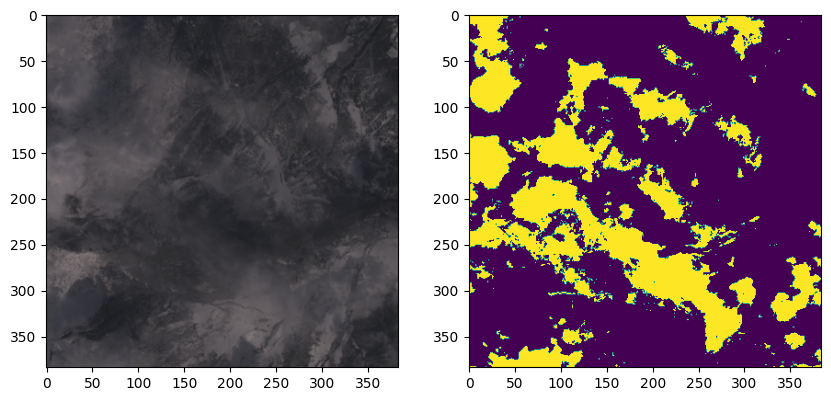

In [111]:
image_index = 7890
fig, ax = plt.subplots(1, 2, figsize=(10, 9))
ax[0].imshow(data.to_array(image_index))
ax[1].imshow(data.to_mask(image_index))